# Kestrel+Model
### A [Bangkit 2021](https://grow.google/intl/id_id/bangkit/) Capstone Project

Kestrel is a TensorFlow powered American Sign Language translator Android app that will make it easier for anyone to seamlessly communicate with people who have vision or hearing impairments. The Kestrel model builds on the state of the art MobileNetV2 model that is optimized for speed and latency on smartphones to accurately recognize and interpret sign language from the phone’s camera and display the translation through a beautiful, convenient and easily accessible Android app.

# American Sign Language 
Fingerspelling alphabets
from the [National Institute on Deafness and Other Communication Disorders (NIDCD)](https://www.nidcd.nih.gov/health/american-sign-language-fingerspelling-alphabets-image) 

<table>
  <tr><td>
    <img src="https://www.nidcd.nih.gov/sites/default/files/Content%20Images/NIDCD-ASL-hands-2019_large.jpg"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://www.nidcd.nih.gov/health/american-sign-language-fingerspelling-alphabets-image">ASL Fingerspelling Alphabets</a> <br/>&nbsp;
  </td></tr>
</table>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initial setup

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import PIL
import PIL.Image
from os import listdir

import pathlib

from tqdm import tqdm
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')


• Using TensorFlow Version: 2.4.1
• Using TensorFlow Hub Version:  0.9.0
• GPU Device Found.


# Data preprocessing

### (Optional) Unzip file on Google Drive

In [ ]:
import zipfile
import pathlib
zip_dir = pathlib.Path('/content/drive/Shareddrives/Kestrel/A - Copy.zip')
unzip_dir = pathlib.Path('/content/drive/Shareddrives/Kestrel/A_Unzipped')
with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

### Loading images from directory

In [2]:
data_dir = pathlib.Path('/Dev/A')

### (Optional) Counting the number of images in the dataset

In [ ]:
image_count = len(list(data_dir.glob('*/color*.png')))
print(image_count)

12547


### (Optional) Displaying one of the "a" letter sign language image:

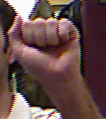

In [ ]:
two = list(data_dir.glob('*/color*.png'))
PIL.Image.open(str(two[0]))

# Create the dataset

Loading the images off disk using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). Define some parameters for the loader:

In [3]:
BATCH_SIZE = 30
IMG_SIZE = (160, 160)

### Coursera method using ImageDataGenerator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)
validation_generator = ImageDataGenerator(
      rescale = 1./255,
      validation_split=0.2)
train_dataset = train_generator.flow_from_directory(data_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    subset='training', 
                                                    target_size = IMG_SIZE,
                                                    shuffle=True,
                                                    )
validation_dataset = validation_generator.flow_from_directory(data_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    subset='validation', 
                                                    target_size = IMG_SIZE,
                                                    shuffle=True,
                                                    )

Found 10046 images belonging to 24 classes.
Found 2501 images belonging to 24 classes.


Splitting images for training and validation

### (Optional) Visualize the data

Show the first 9 images and labels from the training set:

In [ ]:
#@title Showing 9 images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(30, 160, 160, 3)
(30, 24)


### (Deprecated) Create a test set

To create a Test Set, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [ ]:
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batches // 5)
validation_dataset = validation_dataset.skip(validation_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 64
Number of test batches: 15


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Create the model

### Create the base model from the pre-trained convnets 
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [5]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `224 x 224` image into a `7x7x1280` block of features. Let's see what it does to an example batch of images:

In [6]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 5, 5, 1280)


### Freeze the convolutional base
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [7]:
base_model.trainable = False

In [8]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Adding new layer to the model

In [9]:
last_layer = base_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 1280)


In [10]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.5)(x) 
# Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.3)(x)                  
# Add a final layer for classification
x = layers.Dense  (24, activation='softmax')(x)           

model = Model( base_model.input, x) 
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# !pip install scipy

### Training the model

In [12]:
checkpoint_path = "TensorFlow_Training_Checkpoint/Kestrel_Training_8_40Dropout0.3/cp.ckpt"

In [13]:
import os
# base_learning_rate = 0.0001
def get_uncompiled_model():
    model = Model( base_model.input, x) 
    return model

def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return tf.keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()

# Create a callback that saves the model's weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True, # Only save a model if `val_loss` has improved.
                                                 verbose=1)

early_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-2 less"
        # min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

model = make_or_restore_model()
history = model.fit(train_dataset, 
                    epochs=40, 
                    validation_data = validation_dataset, 
                    verbose = 1, 
                    callbacks=[model_checkpoint_callback, early_callbacks])# Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

# # EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
# export_dir = 'saved_model/2'

# # YOUR CODE HERE
# tf.saved_model.save(model, export_dir)

Creating a new model
Epoch 1/40
335/335 [==============================] - 86s 246ms/step - loss: 17.2048 - accuracy: 0.3785 - val_loss: 3.1928 - val_accuracy: 0.3942

Epoch 00001: val_accuracy improved from -inf to 0.39424, saving model to TensorFlow_Training_Checkpoint/Kestrel_Training_8_40Dropout0.3\cp.ckpt
Epoch 2/40
335/335 [==============================] - 117s 350ms/step - loss: 1.3426 - accuracy: 0.6470 - val_loss: 1.6084 - val_accuracy: 0.6058

Epoch 00002: val_accuracy improved from 0.39424 to 0.60576, saving model to TensorFlow_Training_Checkpoint/Kestrel_Training_8_40Dropout0.3\cp.ckpt
Epoch 3/40
335/335 [==============================] - 123s 366ms/step - loss: 1.1252 - accuracy: 0.7047 - val_loss: 1.9808 - val_accuracy: 0.6230

Epoch 00003: val_accuracy improved from 0.60576 to 0.62295, saving model to TensorFlow_Training_Checkpoint/Kestrel_Training_8_40Dropout0.3\cp.ckpt
Epoch 4/40
335/335 [==============================] - 148s 444ms/step - loss: 1.0655 - accuracy: 0.7

### Plotting the accuracy and loss

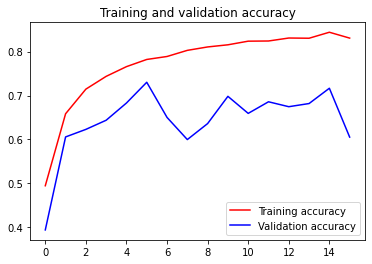

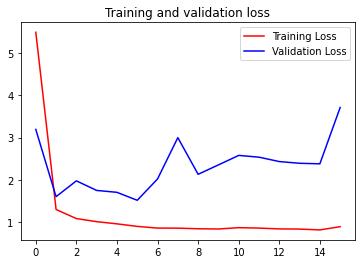

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Exporting to TFLite
You will now save the model to TFLite. We should note, that you will probably see some warning messages when running the code below. These warnings have to do with software updates and should not cause any errors or prevent your code from running. 


In [15]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/8_40Dropout0.3'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/8_40Dropout0.3\assets


In [ ]:
# # Select mode of optimization
# mode = "Speed" 

# if mode == 'Storage':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
# elif mode == 'Speed':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
# else:
#     optimization = tf.lite.Optimize.DEFAULT

In [16]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) # YOUR CODE HERE

# Set the optimzations
converter.optimizations = [tf.lite.Optimize.DEFAULT]# YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()# YOUR CODE HERE

In [17]:
tflite_model_file = pathlib.Path('saved_model/8_40Dropout0.3/model.tflite')
tflite_model_file.write_bytes(tflite_model)

35424192

In [ ]:
# path_to_pb = "C:/saved_model/saved_model.pb"
# def load_pb(path_to_pb):
#     with tf.gfile.GFile(path_to_pb, "rb") as f:
#         graph_def = tf.GraphDef()
#         graph_def.ParseFromString(f.read())
#     with tf.Graph().as_default() as graph:
#         tf.import_graph_def(graph_def, name='')
#         return graph
#         print(graph)

# Test the model with TFLite interpreter

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []
test_batches = data_dir.map(format_example).batch(1)
for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

AttributeError: ignored

In [ ]:
# Utilities functions for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
# Visualize the outputs

# Select index of image to display. Minimum index value is 1 and max index value is 50. 
index = 5 

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(index, predictions, test_labels)
plt.show()